In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from pytorchtools_Transformer_coppie import EarlyStopping

from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR

import scipy.stats as st

from matplotlib.offsetbox import AnchoredText
import math

In [3]:
#GPU
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

Using cpu device


In [4]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout = 0.1, max_len = 512):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [5]:
class Transformer(nn.Module):
    def __init__(self, d_model, num_layers, p, neg_slope, n_head, pos_dropout):
        super(Transformer, self).__init__()

        self.dmodel = d_model
        self.encoder_layer = nn.TransformerEncoderLayer(d_model = d_model, nhead = n_head, dim_feedforward = 2048, dropout = 0.25, batch_first = False, dtype = torch.float)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer = self.encoder_layer, num_layers = num_layers)
        self.pos_encoder = PositionalEncoding(d_model = d_model, dropout = pos_dropout)
        
        self.linear = nn.Linear(3, d_model)
        
        self.fcff = nn.Sequential(
          
            nn.Linear(512, 1200, device = device),
            nn.BatchNorm1d(1200),
            nn.Dropout1d(p = p),
            nn.LeakyReLU(neg_slope),
            
            nn.Linear(1200, 450, device = device),
            nn.BatchNorm1d(450),
            nn.Dropout1d(p = p),
            nn.LeakyReLU(neg_slope),

            nn.Linear(450, 30, device = device),
            nn.BatchNorm1d(30),
            nn.Dropout1d(p = p),
            nn.LeakyReLU(neg_slope),

            nn.Linear(30, 2,  device = device),
        )
        
        self.apply(self._init_weights)
    
    def _init_weights(self,module):
        
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, 0, 0.1)
            if module.bias is not None:
                module.bias.data.fill_(0.08)
        
    
    def forward(self, x1, x2):

        x1 = x1.permute(1, 0, 2)
        x1 = self.linear(x1)
        x1 = self.pos_encoder(x1 * torch.sqrt(torch.tensor(self.dmodel)))
        x1 = self.transformer_encoder(x1)
        x1 = x1.permute(1, 0, 2)
        x1 = torch.flatten(x1, 1)
        x1 = self.fcff(x1)

        x2 = x2.permute(1, 0, 2)
        x2 = self.linear(x2)
        x2 = self.pos_encoder(x2 * torch.sqrt(torch.tensor(self.dmodel)))
        x2 = self.transformer_encoder(x2)
        x2 = x2.permute(1, 0, 2)
        x2 = torch.flatten(x2, 1)
        x2 = self.fcff(x2)
        
        return torch.stack([x1, x2])

In [6]:
class MyLoss (nn.Sequential):
    def __init__(self):
        super(MyLoss, self).__init__()

    def forward(self, W, E):
        
        xw = torch.nonzero(W, as_tuple = False)[:,0]
        
        W = W[xw]
        E = E[xw]

        loss = torch.mean(torch.abs(E-W)/W).to(device)

        return loss

In [7]:
def Reg_Loss(loss, LAMBDA):
    
    l2_reg = 0
    for W in model.parameters():
        l2_reg = l2_reg + torch.norm(W, 1)
    
    loss_reg = loss + LAMBDA*l2_reg
    
    return loss_reg

In [8]:
def Dist(W, E):
    
    x = torch.nonzero(W, as_tuple = False)[:,0]
    
    W = W[x]
    E = E[x]
    
    return E/W

In [9]:
def datasetmaker(data, val_max):
    return torch.stack([data[:int(val_max/2)], data[int(val_max/2):val_max]])

In [10]:
def w_dist_excavator(W, val_min, val_max):
    return W[torch.arange(val_min), torch.arange(val_min, val_max)]

In [11]:
def batchesmaker(data, n_batch, dim):#dim = 1 data, dim = 0 W
    return torch.stack(torch.chunk(data, n_batch, dim = dim), dim = dim)

Validation loss decreased (inf --> 0.576904).  Saving model ...


KeyboardInterrupt: 

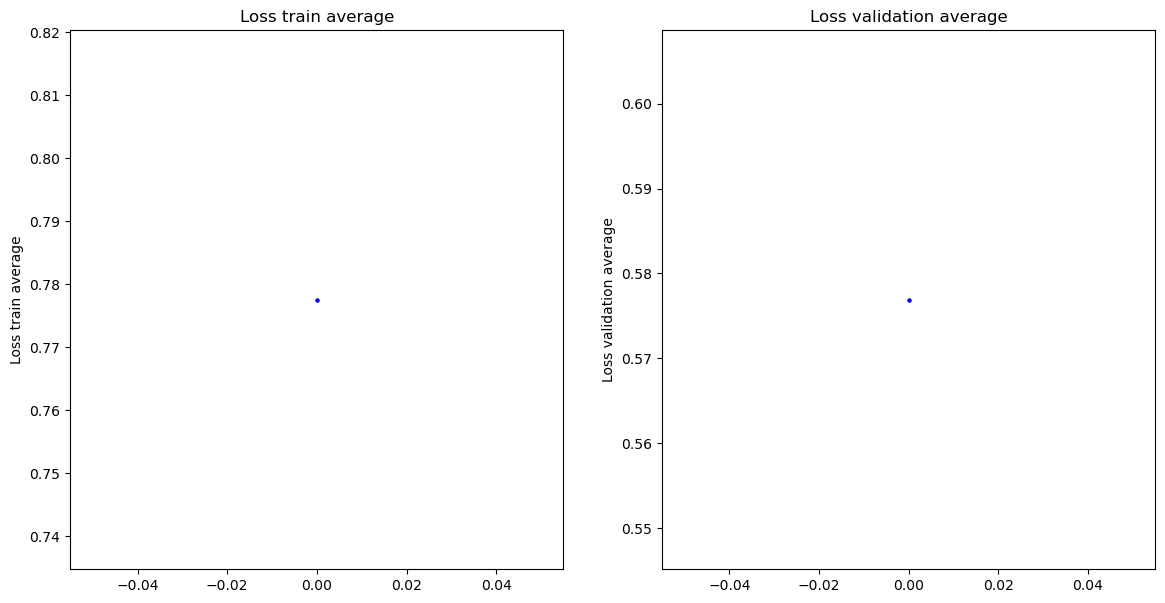

In [14]:
#Dataloder

train, targets_train = torch.load('/home/gbortolai/Thesis/data/Jets/dataset_train-coppie', map_location=device)
validation, targets_validation  = torch.load('/home/gbortolai/Thesis/data/Jets/dataset_validation-coppie', map_location=device)

W_dist_train, targets_train = torch.load('/home/gbortolai/Thesis/data/Jets/Wasserstein_dist_train-coppie_s=100000', map_location=device)
W_dist_validation, targets_validation = torch.load('/home/gbortolai/Thesis/data/Jets/Wasserstein_dist_validation-coppie_s=20000', map_location=device)

#parameters

n_sample_train = train.size(0)
n_sample_validation = validation.size(0)

batch_size = 100

n_batches_train = int(n_sample_train/batch_size)

train = datasetmaker(train, n_sample_train)
train = batchesmaker(train, n_batches_train, 1)
# W_dist_train = w_dist_excavator(W_dist_train, 6000, 120)
W_dist_train = batchesmaker(W_dist_train, n_batches_train, 0)

validation = datasetmaker(validation, validation.size(0))
# W_dist_validation = w_dist_excavator(W_dist_validation, 600, 1200)

train = train.to(torch.float)
validation = validation.to(torch.float)


d_model = 32
num_layers = 2
n_head = 4
pos_dropout = 0.1

#Train
#-----------------------------------------------------------------------------------------------------------SETTING
learning_rate = 1e-3

criterion = MyLoss()
#criterion = nn.MSELoss()

LAMBDA = 0


patience = 30

iteration = 1000

counter_train = 0 
counter_validation = 0

neg_slope = 0

p = 0.1

model = Transformer(d_model, num_layers, p, neg_slope, n_head, pos_dropout).to(device)#modificare

optimizer = optim.Adam(model.parameters(),lr = learning_rate, weight_decay = 0)#, betas=(0.9, 0.99), eps=1e-5 ,weight_decay=0)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.5)

pdist = nn.PairwiseDistance(p=2, eps = 0)


fig = plt.figure(figsize = (14, 7), constrained_layout=False)
gs = GridSpec(1, 2, figure = fig)

ax3 = fig.add_subplot(gs[0, 0])
ax3.set_title('Loss train average')
ax3.set_ylabel('Loss train average')
ax3.set_ybound(lower = 0, upper = None)

ax4 = fig.add_subplot(gs[0, 1])
ax4.set_title('Loss validation average')
ax4.set_ylabel('Loss validation average')
ax4.set_ybound(lower = 0, upper = None)

#ax5 = fig.add_subplot(gs[0, 0])
#ax5.set_title('Distortion validation')
#ax5.set_ylabel('Distortion')
#ax5.axvline(x=1, color='r', linestyle='-')
#ax5.set_xlim(-0.1, 4)
#ax5.set_ylim(-0.1, 0.5)

#fig.suptitle("MNIST and lr= "+str(learning_rate)+'p value is:'+str(p)+'la loss é:MyLoss')

train_losses = []


early_stopping = EarlyStopping(patience = patience, verbose = True)

#---------------------------------------------------------------------------------NN
for ite in range (iteration):
    #Train
    #---------------------------------------------------------------------------TRAIN
    model.train()
    for batch in range (n_batches_train):
        #embedding
        sample_emb_train = model(train[0][batch], train[1][batch]).to(device)

        E_dist_train = pdist(sample_emb_train[0], sample_emb_train[1]).to(device) 

        loss = criterion(W_dist_train[batch], E_dist_train)
        # dist = Dist(W_dist_train[batch], E_dist_train)
        loss_reg = Reg_Loss(loss, LAMBDA)
        train_losses.append(loss_reg.item())

        optimizer.zero_grad()
        loss_reg.requires_grad_()
        loss_reg.backward(retain_graph=True)

        optimizer.step()
#----------------------------------------------------------------------------------------------------------------------VALIDATION
    train_loss = np.average(train_losses)
    ax3.scatter(ite,train_loss,color='b', s=5)
    
    #Validation
    model.eval()
    #embedding
    sample_emb_validation = model(validation[0], validation[1]).to(device)

    E_dist_validation = pdist(sample_emb_validation[0], sample_emb_validation[1]).to(device)

    valid_loss = criterion(W_dist_validation, E_dist_validation)
    # valid_dist = Dist(W_dist_validation, E_dist_validation)

#------------------------------------------------------------------------------------------PLOT
    ax4.scatter(ite, valid_loss.cpu().detach().numpy(),color='b', s=5)

    train_losses = []

    early_stopping(valid_loss, model)
    scheduler.step()


    if early_stopping.early_stop:
            print("Early stopping")
            break

In [29]:
test, targets_test = torch.load('/home/gbortolai/Thesis/data/Jets/dataset_test-coppie', map_location=device)
W_dist_test, target_test = torch.load('/home/gbortolai/Thesis/data/Jets/Wasserstein_dist_test-coppie_s=20000', map_location=device)

test = datasetmaker(test, test.size(0))
targets_test = datasetmaker(targets_test, targets_test.size(0))

# W_dist_test = w_dist_excavator(W_dist_test, 2000, 4000)

test = test.to(torch.float)

criterion = MyLoss()
#criterion = nn.MSELoss()

neg_slope = 1e-2

p = 0.1

d_model = 32
num_layers = 2
n_head = 4
pos_dropout = 0.1

pdist = nn.PairwiseDistance(p=2, eps = 0)


model = Transformer(d_model, num_layers, p, neg_slope, n_head, pos_dropout).to(device)


#test 
model.load_state_dict(torch.load('/home/gbortolai/Thesis/Checkpoint/checkpoint_transformer-coppie.pth', map_location = device))
#-----------------------------------------------------------------------------------SETTING
model.eval()
#--------------------------------------------------------------------------------------EMBEDDING

sample_emb_test = model(test[0], test[1]).to(device)

E_dist_test = pdist(sample_emb_test[0], sample_emb_test[1]).to(device)

test_loss = criterion(W_dist_test, E_dist_test)
test_dist = Dist(W_dist_test, E_dist_test)
# test_loss_reg = Reg_Loss(test_loss, LAMBDA)

test_dist_mean = torch.mean(test_dist)
var_test = np.sqrt(torch.mean((1-test_dist_mean)*(1-test_dist_mean)).cpu().detach().numpy())

median_test = torch.median(test_dist)

print('Dist mean:', test_dist_mean.item(),u"\u00B1", var_test.item())

Dist mean: 0.7780671945210268 ± 0.2219328054789732


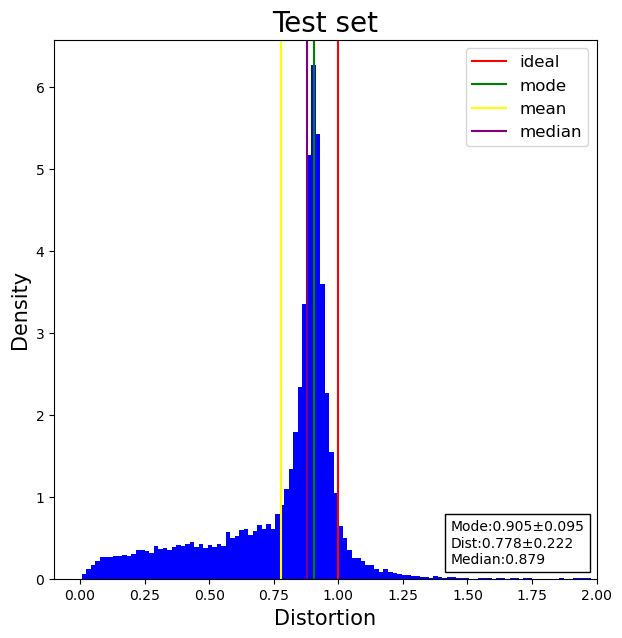

In [30]:
fig3, ax3_test = plt.subplots(1,1, figsize=(7,7))

ax3_test.set_title('Test set', fontsize = 20)

ax3_test.set_xlim([-0.1,2])
ax3_test.set_xlabel("Distortion", fontsize = 15)
ax3_test.set_ylabel("Density", fontsize = 15)
labels = ['ideal', 'mode', 'mean','median']
#plt.axhline(y=1, color='r', linestyle='-')
#for i in range(targets_test.size(0)):
    #if targets_test[i] == 2:
count_test, bins_test, p_test = ax3_test.hist(test_dist.cpu().detach().numpy(), color = 'b', bins = 'auto', density = True)
ax3_test.axvline(x=1, color='r', linestyle='-')

mode_index_test = count_test.argmax()
mode_test = (bins_test[mode_index_test] + bins_test[mode_index_test+1])/2
var_mode_test = np.sqrt(np.average((1-mode_test)*(1-mode_test)))

ax3_test.axvline(x=mode_test, color='green', linestyle='-')
ax3_test.axvline(x=test_dist_mean.cpu().detach().numpy(), color='yellow', linestyle='-')
ax3_test.axvline(x=median_test.cpu().detach().numpy(), color='purple', linestyle='-')
#plt.axvline(x=test_loss.detach().numpy(), color='orange', linestyle='-')
ax3_test.legend(labels, fontsize = 12)

anchored_text_test = AnchoredText('Mode:'+str('%.3f' % mode_test.item())+u"\u00B1"+str('%.3f' % var_mode_test.item())+'\nDist:'+str('%.3f' % test_dist_mean.item())+u"\u00B1"+str('%.3f' % var_test.item()+'\nMedian:'+str('%.3f' % median_test.item())), loc='lower right')
ax3_test.add_artist(anchored_text_test)


In [77]:
fig3.savefig('/home/gbortolai/Thesis/Plot/Jets/Transformer.pdf', facecolor='w',pad_inches=0.3, transparent=True)

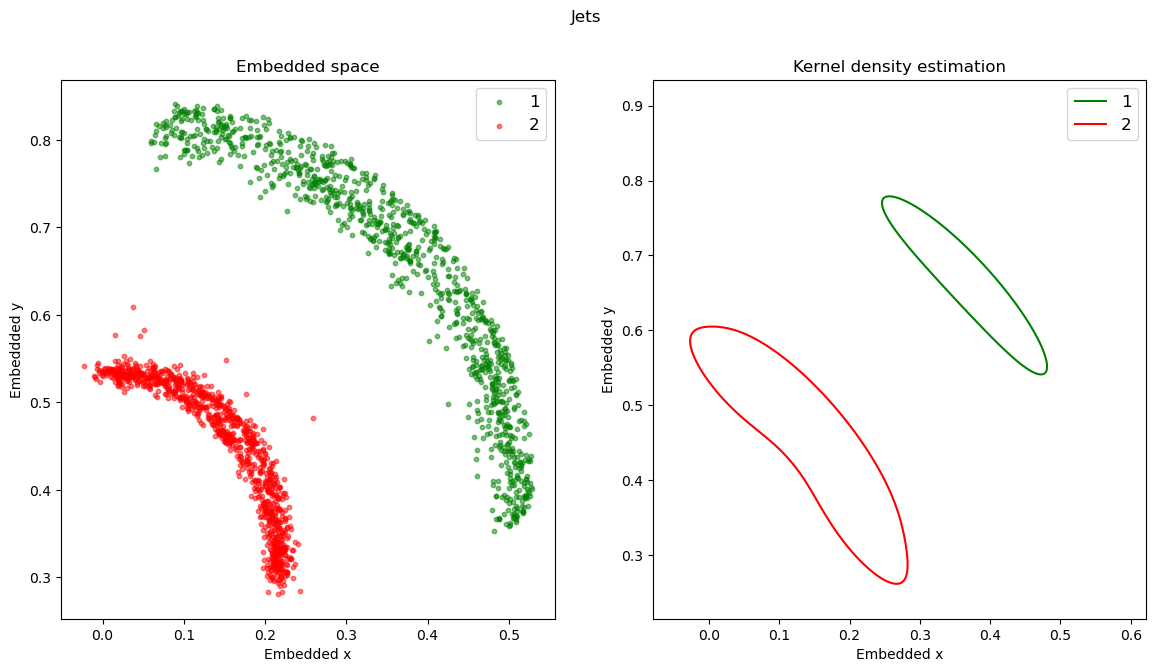

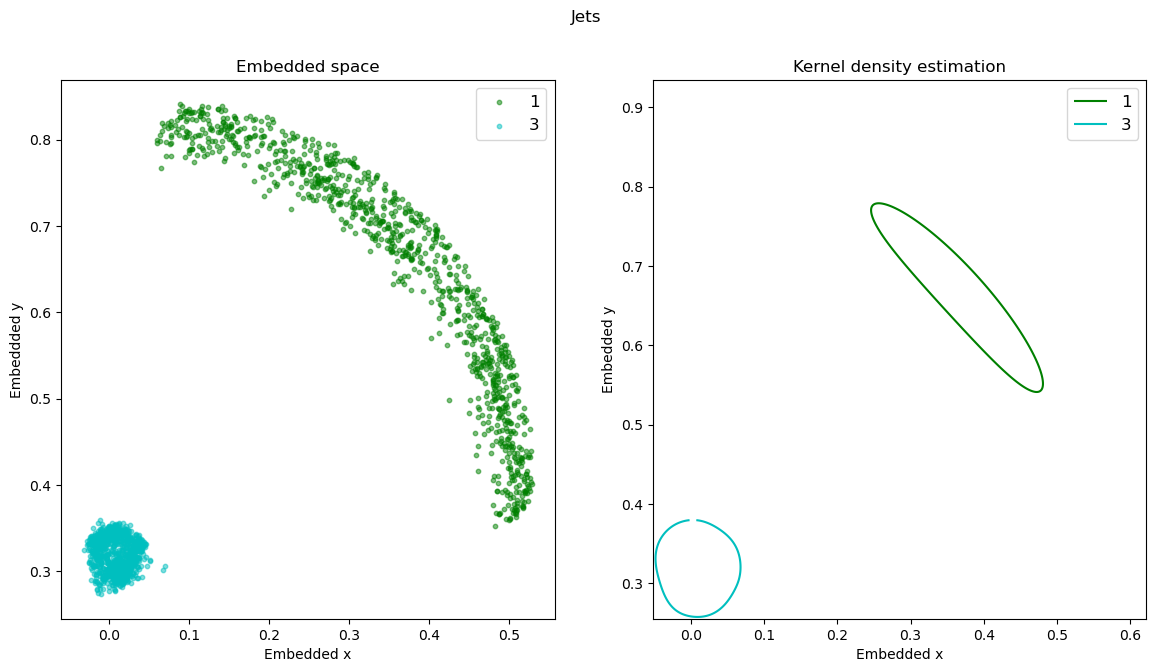

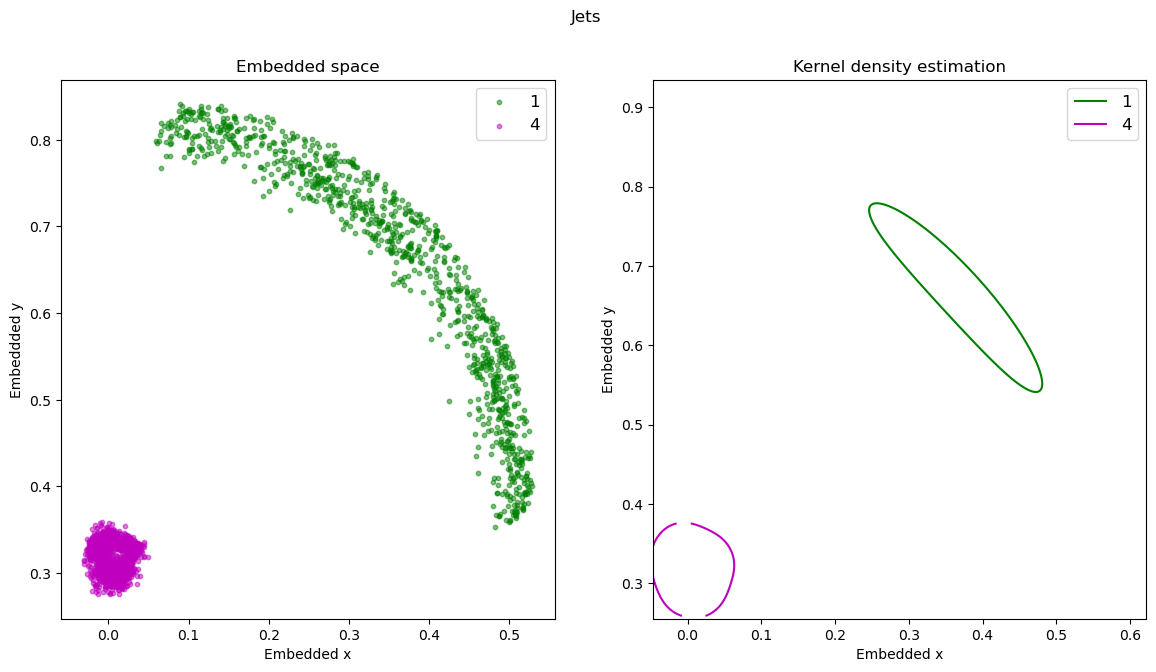

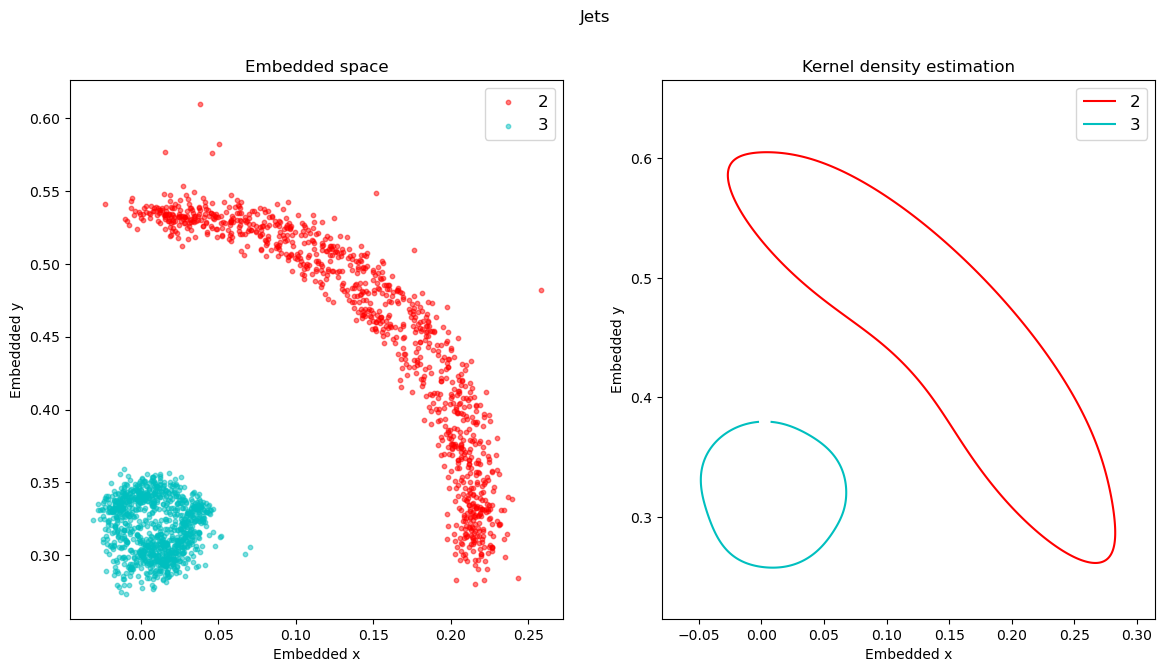

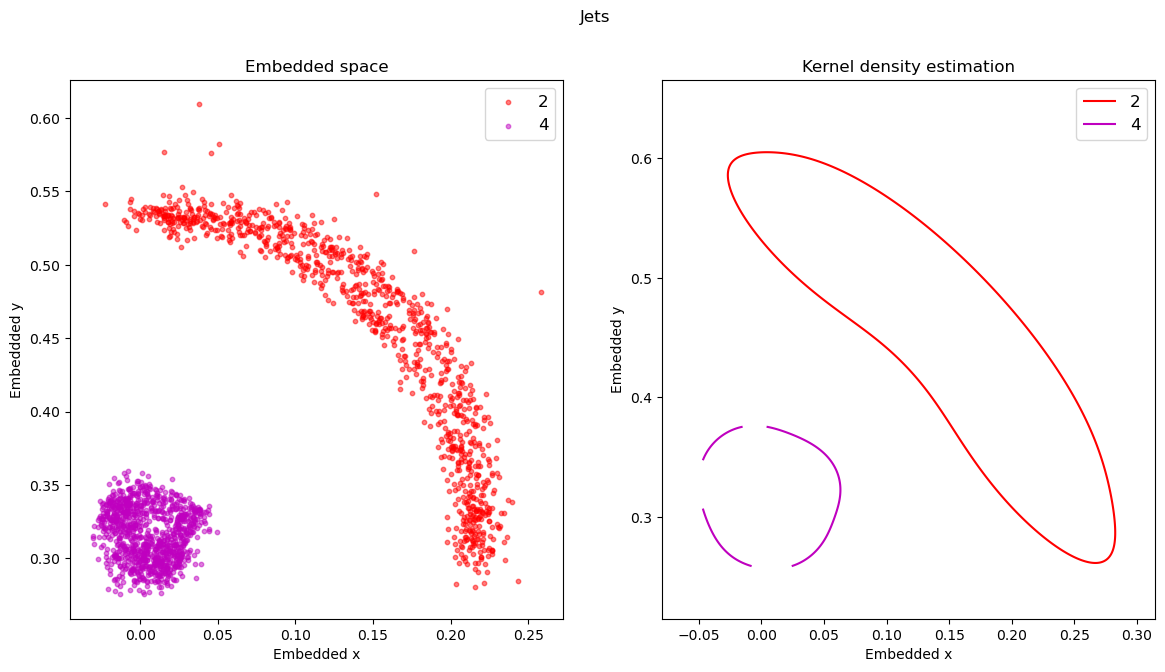

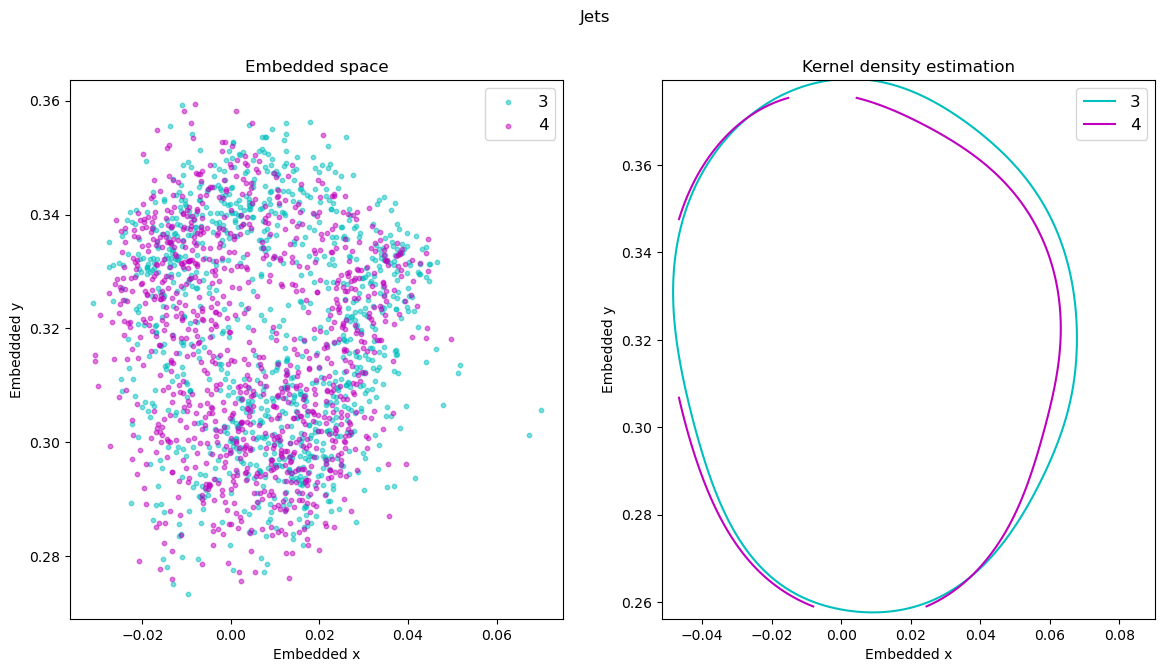

In [37]:
#------------------------------------------------------------------------------------PLOT
labels = ['1','2','3','4']

colors = ['g', 'r','c','m']

var, col = [], []

n_bullet = 0
n_target = 0

for n_bullet in [1,2,3,4]:
    for n_target in [1,2,3,4]:
        if n_target > n_bullet:
            fig_test = plt.figure(figsize=(14, 7), constrained_layout=False)
            gs_test = GridSpec(1, 2, figure = fig_test)

            fig_test.suptitle('Jets')

            ax1_test = fig_test.add_subplot(gs_test[0, 1])
            ax1_test.set_title('Kernel density estimation')
            ax1_test.set_xlabel('Embedded x')
            ax1_test.set_ylabel('Embedded y')

            ax2_test = fig_test.add_subplot(gs_test[0,0])
            ax2_test.set_title('Embedded space')
            ax2_test.set_xlabel('Embedded x')
            ax2_test.set_ylabel('Embeddded y')

            for j in [n_bullet,n_target]:
                for i in torch.nonzero( targets_test == j)[:,0]:
                    ax2_test.scatter(sample_emb_test[0][i][0].cpu().detach().numpy(), sample_emb_test[0][i][1].cpu().detach().numpy(), color = colors[j-1], s=10, alpha = 0.5)
                var.append(labels[j-1])
                col.append(colors[j-1])

            ax2_test.legend(var,loc = 'best', fontsize = 12)

            leg = ax2_test.get_legend()    
            for i in range(len(var)):

                leg.legend_handles[i].set_color(col[i])
            #------------------------------------------------------KDE
            #fig, ax = plt.subplots()

            h = []

            for k in [n_bullet,n_target]:
                ind = torch.count_nonzero(targets_test == k)
                X = torch.zeros(1,1).expand(ind, 2).clone()

                l=0
                for i in torch.nonzero(targets_test == k)[:,0]:

                    X[l] = sample_emb_test[0][i]
                    l = l+1


                # Extract x and y
                x = X[:, 0]
                y = X[:, 1]

                # Define the borders
                deltaX = (torch.max(x) - torch.min(x))/5
                deltaY = (torch.max(y) - torch.min(y))/5
                xmin = torch.min(x).item() - deltaX.item()
                xmax = torch.max(x).item() + deltaX.item()
                ymin = torch.min(y).item() - deltaY.item()
                ymax = torch.max(y).item() + deltaX.item()

                # Create meshgrid
                xx, yy = np.mgrid[xmin:xmax:1000j, ymin:ymax:1000j]

                x = x.detach().numpy()
                y = y.detach().numpy()

                positions = np.vstack([xx.ravel(), yy.ravel()])
                values = np.vstack([x, y])

                kernel = st.gaussian_kde(values)
                # kernel.set_bandwidth(bw_method=0.5)

                f = np.reshape(kernel(positions).T, xx.shape)


                #ax1_test = plt.gca()
                cset = ax1_test.contour(xx, yy, f, levels = [10], colors=colors[k-1])
                h1, l1 = cset.legend_elements()
                h.append(h1[0])

            ax1_test.legend(h, var, loc = 'best', fontsize = 12)
            var, col, h = [], [], [] 
            # fig_test.savefig('/home/gbortolai/Thesis/Plot/MNIST/Emb/CNN-paper/MyLoss/KDE'+str([n_bullet,n_target])+'.pdf', facecolor='w',pad_inches=0.3, transparent=True)
plt.show()

In [ ]:
torch.save([sample_emb_test, targets_test],'/home/gbortolai/Thesis/data/MNIST/sample_emb_test_s='+str(test.size(0)))

In [ ]:
fig_test.savefig('/home/gbortolai/Thesis/Plot/MNIST/Embedding.pdf', facecolor='w',pad_inches=0.3, transparent=True)

In [73]:
#plotting E_dist emb

E = torch.cdist(sample_emb_test[0], sample_emb_test[0], p = 2)
torch.save([E, targets_test],'/home/gbortolai/Thesis/data/Jets/E_dist_emb_transformer_s='+str(test.size(0)))

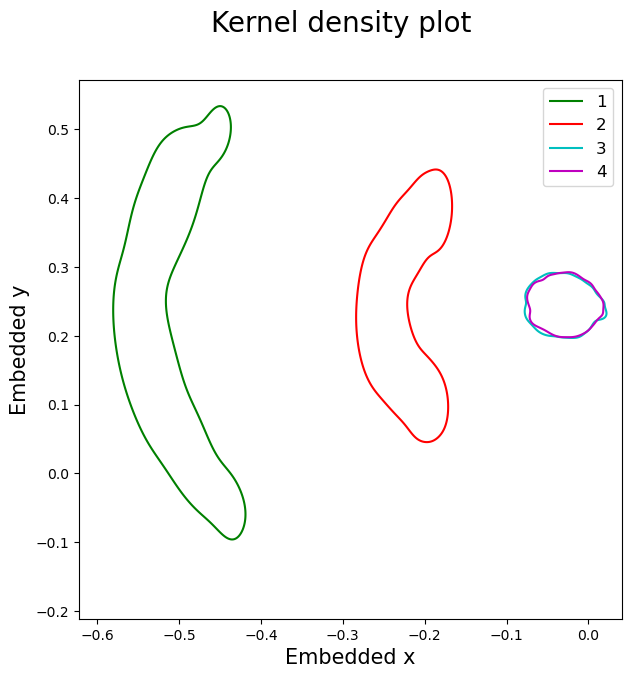

In [76]:
labels = ['1','2','3','4']

colors = ['g', 'r','c','m']

fig, ax = plt.subplots(1,1, figsize = (7,7))
fig.suptitle('Kernel density plot', fontsize = 20)
ax.set_xlabel('Embedded x', fontsize = 15)
ax.set_ylabel('Embedded y', fontsize = 15)

lab, h = [], []

for k in [1,2,3,4]:
    ind = torch.count_nonzero(targets_test == k)
    X = torch.zeros(1,1).expand(ind, 2).clone()

    l=0
    for i in torch.nonzero(targets_test == k)[:,0]:
        X[l] = sample_emb_test[0][i]
        l = l+1


    # Extract x and y
    x = X[:, 0]
    y = X[:, 1]

    # Define the borders
    deltaX = (torch.max(x) - torch.min(x))/5
    deltaY = (torch.max(y) - torch.min(y))/5
    xmin = torch.min(x).item() - deltaX.item()
    xmax = torch.max(x).item() + deltaX.item()
    ymin = torch.min(y).item() - deltaY.item()
    ymax = torch.max(y).item() + deltaX.item()

    # Create meshgrid
    xx, yy = np.mgrid[xmin:xmax:1000j, ymin:ymax:1000j]

    x = x.detach().numpy()
    y = y.detach().numpy()

    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])

    kernel = st.gaussian_kde(values)
    # kernel.set_bandwidth(bw_method=0.8)

    f = np.reshape(kernel(positions).T, xx.shape)


    #ax1_test = plt.gca()
    #print(colors[k])
    cset = ax.contour(xx, yy, f, levels = [10], colors = colors[k-1])

    h1, l1 = cset.legend_elements()
    h.append(h1[0])
    lab.append(labels[k-1])

ax.legend(h, lab, loc = 'best', fontsize = 12)
# fig.savefig('/home/gbortolai/Thesis/Plot/Jets/KDE_1234_myloss_Transformer.pdf', facecolor='w',pad_inches=0.3, transparent=True)
lab, h = [], []

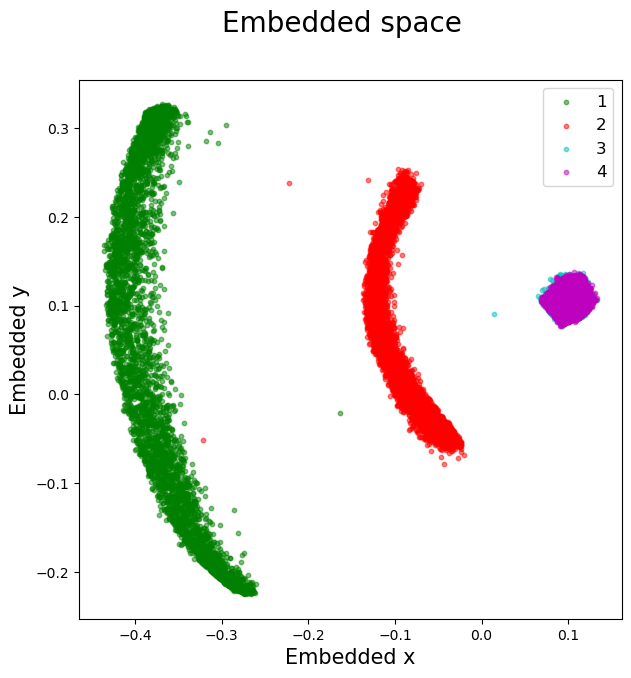

In [31]:
labels = ['1','2','3','4']

colors = ['g', 'r','c','m']

var, col = [], []

fig, ax = plt.subplots(1,1, figsize = (7,7))

fig.suptitle('Embedded space', fontsize = 20)
ax.set_xlabel('Embedded x', fontsize = 15)
ax.set_ylabel('Embedded y', fontsize = 15)

for j in [1,2,3,4]:
    for i in torch.nonzero(targets_test[0] == j)[:,0]:
        ax.scatter(sample_emb_test[0][i][0].cpu().detach().numpy(), sample_emb_test[0][i][1].cpu().detach().numpy(), color = colors[j-1], s=10, alpha = 0.5)
    # for i in torch.nonzero(targets_test[1] == j)[:,0]:
    #     ax.scatter(sample_emb_test[0][i][0].cpu().detach().numpy(), sample_emb_test[0][i][1].cpu().detach().numpy(), color = colors[j-1], s=10, alpha = 0.5)
        
    var.append(labels[j-1])
    col.append(colors[j-1])
    
ax.legend(var,loc = 'best', fontsize = 12)

leg = ax.get_legend()    
for i in range(len(var)):

    leg.legend_handles[i].set_color(col[i])
    
# fig.savefig('/home/gbortolai/Thesis/Plot/Jets/Embedded_1234_myloss_transformer-coppie.pdf', facecolor='w',pad_inches=0.3, transparent=True)
var, col = [], []

In [32]:
fig.savefig('/home/gbortolai/Thesis/Plot/Jets/Embedded_1234_myloss_transformer-coppie.pdf', facecolor='w',pad_inches=0.3, transparent=True)